In [348]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns



sk.set_config(display='diagram')

# Functions

# Load Data

In [349]:
train_df = pd.read_csv('./data/moneyball-training-data.csv')
train_df.drop(labels=['TEAM_BATTING_HBP','TEAM_BASERUN_CS'], axis=1, inplace=True)

train_df.drop(['INDEX'], axis=1, inplace=True)
train_df.reindex()

train_df['TEAM_BATTING_1B'] = train_df['TEAM_BATTING_H'] - train_df['TEAM_BATTING_2B'] - train_df['TEAM_BATTING_3B'] - train_df['TEAM_BATTING_HR']
train_df.drop(['TEAM_BATTING_H'], axis=1, inplace=True)

#train_df.dropna(inplace=True)
train_df

,TARGET_WINS,TEAM_BATTING_2B,TEAM_BATTING_3B,TEAM_BATTING_HR,TEAM_BATTING_BB,TEAM_BATTING_SO,TEAM_BASERUN_SB,TEAM_PITCHING_H,TEAM_PITCHING_HR,TEAM_PITCHING_BB,TEAM_PITCHING_SO,TEAM_FIELDING_E,TEAM_FIELDING_DP,TEAM_BATTING_1B
0,39,194,39,13,143,842.0,NaN,9364,84,927,5456.0,1011,NaN,1199
1,70,219,22,190,685,1075.0,37.0,1347,191,689,1082.0,193,155.0,908
2,86,232,35,137,602,917.0,46.0,1377,137,602,917.0,175,153.0,973
3,70,209,38,96,451,922.0,43.0,1396,97,454,928.0,164,156.0,1044
4,82,186,27,102,472,920.0,49.0,1297,102,472,920.0,138,168.0,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,83,294,25,144,522,990.0,100.0,1404,144,522,990.0,102,152.0,941
2272,67,276,27,151,496,925.0,109.0,1361,151,496,925.0,99,171.0,907
2273,81,311,32,117,491,1090.0,45.0,1367,117,491,1090.0,92,156.0,907
2274,71,322,22,164,594,1156.0,123.0,1437,164,594,1156.0,131,123.0,929


In [350]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276 entries, 0 to 2275
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TARGET_WINS       2276 non-null   int64  
 1   TEAM_BATTING_2B   2276 non-null   int64  
 2   TEAM_BATTING_3B   2276 non-null   int64  
 3   TEAM_BATTING_HR   2276 non-null   int64  
 4   TEAM_BATTING_BB   2276 non-null   int64  
 5   TEAM_BATTING_SO   2174 non-null   float64
 6   TEAM_BASERUN_SB   2145 non-null   float64
 7   TEAM_PITCHING_H   2276 non-null   int64  
 8   TEAM_PITCHING_HR  2276 non-null   int64  
 9   TEAM_PITCHING_BB  2276 non-null   int64  
 10  TEAM_PITCHING_SO  2174 non-null   float64
 11  TEAM_FIELDING_E   2276 non-null   int64  
 12  TEAM_FIELDING_DP  1990 non-null   float64
 13  TEAM_BATTING_1B   2276 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 249.1 KB


In [351]:
print(train_df.isna().sum().sort_values())

TARGET_WINS           0
TEAM_BATTING_2B       0
TEAM_BATTING_3B       0
TEAM_BATTING_HR       0
TEAM_BATTING_BB       0
TEAM_PITCHING_H       0
TEAM_PITCHING_HR      0
TEAM_PITCHING_BB      0
TEAM_FIELDING_E       0
TEAM_BATTING_1B       0
TEAM_BATTING_SO     102
TEAM_PITCHING_SO    102
TEAM_BASERUN_SB     131
TEAM_FIELDING_DP    286
dtype: int64


In [352]:
train_df.isnull().sum() / len(train_df)

TARGET_WINS         0.000000
TEAM_BATTING_2B     0.000000
TEAM_BATTING_3B     0.000000
TEAM_BATTING_HR     0.000000
TEAM_BATTING_BB     0.000000
TEAM_BATTING_SO     0.044815
TEAM_BASERUN_SB     0.057557
TEAM_PITCHING_H     0.000000
TEAM_PITCHING_HR    0.000000
TEAM_PITCHING_BB    0.000000
TEAM_PITCHING_SO    0.044815
TEAM_FIELDING_E     0.000000
TEAM_FIELDING_DP    0.125659
TEAM_BATTING_1B     0.000000
dtype: float64

In [353]:
train_df.describe()

,TARGET_WINS,TEAM_BATTING_2B,TEAM_BATTING_3B,TEAM_BATTING_HR,TEAM_BATTING_BB,TEAM_BATTING_SO,TEAM_BASERUN_SB,TEAM_PITCHING_H,TEAM_PITCHING_HR,TEAM_PITCHING_BB,TEAM_PITCHING_SO,TEAM_FIELDING_E,TEAM_FIELDING_DP,TEAM_BATTING_1B
count,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2174.000000,2145.000000,2276.000000,2276.000000,2276.000000,2174.000000,2276.000000,1990.000000,2276.000000
mean,80.790861,241.246924,55.250000,99.612039,501.558875,735.605336,124.761772,1779.210457,105.698594,553.007909,817.730451,246.480668,146.387940,1073.160808
std,15.752152,46.801415,27.938557,60.546872,122.670862,248.526418,87.791166,1406.842930,61.298747,166.357362,553.085031,227.770972,26.226385,128.924643
min,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1137.000000,0.000000,0.000000,0.000000,65.000000,52.000000,709.000000
25%,71.000000,208.000000,34.000000,42.000000,451.000000,548.000000,66.000000,1419.000000,50.000000,476.000000,615.000000,127.000000,131.000000,990.750000
50%,82.000000,238.000000,47.000000,102.000000,512.000000,750.000000,101.000000,1518.000000,107.000000,536.500000,813.500000,159.000000,149.000000,1050.000000
75%,92.000000,273.000000,72.000000,147.000000,580.000000,930.000000,156.000000,1682.500000,150.000000,611.000000,968.000000,249.250000,164.000000,1129.000000
max,146.000000,458.000000,223.000000,264.000000,878.000000,1399.000000,697.000000,30132.000000,343.000000,3645.000000,19278.000000,1898.000000,228.000000,2112.000000


In [354]:
train_df.kurtosis()

TARGET_WINS           1.035926
TEAM_BATTING_2B       0.011464
TEAM_BATTING_3B       1.513159
TEAM_BATTING_HR      -0.960802
TEAM_BATTING_BB       2.194866
TEAM_BATTING_SO      -0.316301
TEAM_BASERUN_SB       5.513236
TEAM_PITCHING_H     142.282071
TEAM_PITCHING_HR     -0.601210
TEAM_PITCHING_BB     97.271737
TEAM_PITCHING_SO    673.360215
TEAM_FIELDING_E      11.009362
TEAM_FIELDING_DP      0.188427
TEAM_BATTING_1B       8.559600
dtype: float64

In [355]:
train_df.skew()

TARGET_WINS         -0.399249
TEAM_BATTING_2B      0.215386
TEAM_BATTING_3B      1.110929
TEAM_BATTING_HR      0.186288
TEAM_BATTING_BB     -1.027113
TEAM_BATTING_SO     -0.298211
TEAM_BASERUN_SB      1.975176
TEAM_PITCHING_H     10.343140
TEAM_PITCHING_HR     0.288167
TEAM_PITCHING_BB     6.752798
TEAM_PITCHING_SO    22.205186
TEAM_FIELDING_E      2.994411
TEAM_FIELDING_DP    -0.389526
TEAM_BATTING_1B      2.049519
dtype: float64

In [356]:
#_pl = train_df.hist()

In [357]:
#sns.set_palette('colorblind')
#sns.pairplot(data=train_df, height=3)

In [358]:
col_lst = train_df.columns.values.tolist()
col_lst

['TARGET_WINS',
 'TEAM_BATTING_2B',
 'TEAM_BATTING_3B',
 'TEAM_BATTING_HR',
 'TEAM_BATTING_BB',
 'TEAM_BATTING_SO',
 'TEAM_BASERUN_SB',
 'TEAM_PITCHING_H',
 'TEAM_PITCHING_HR',
 'TEAM_PITCHING_BB',
 'TEAM_PITCHING_SO',
 'TEAM_FIELDING_E',
 'TEAM_FIELDING_DP',
 'TEAM_BATTING_1B']

In [359]:
df_long = pd.melt(train_df, value_vars=col_lst)
df_long

,variable,value
0,TARGET_WINS,39.0
1,TARGET_WINS,70.0
2,TARGET_WINS,86.0
3,TARGET_WINS,70.0
4,TARGET_WINS,82.0
...,...,...
31859,TEAM_BATTING_1B,941.0
31860,TEAM_BATTING_1B,907.0
31861,TEAM_BATTING_1B,907.0
31862,TEAM_BATTING_1B,929.0


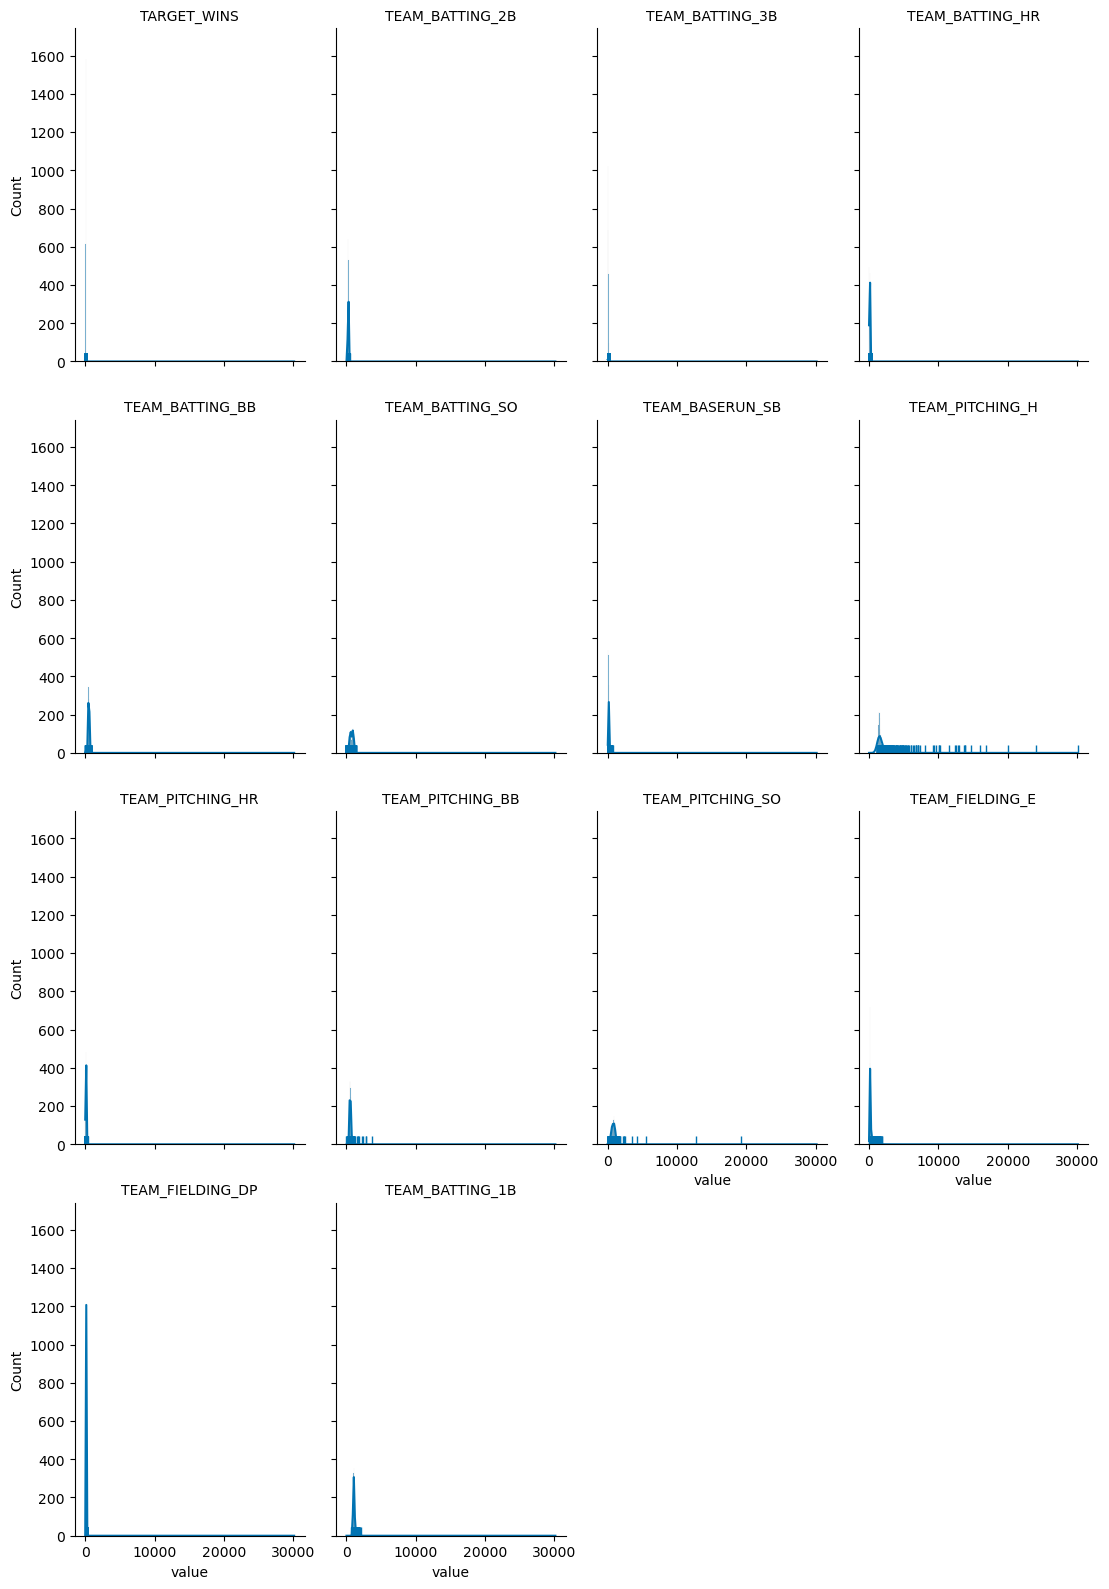

In [360]:
g = sns.displot(data=df_long, x="value", col="variable", col_wrap=4, rug=True,
                 height=4, aspect=.7, kde=True)

g.set_axis_labels("value")
g.set_titles("{col_name}")

In [361]:
# Visualizing multicollinearity between independent features using a heatmap  
  
corr = train_df.corr()  
print('Pearson correlation coefficient matrix for each independent variable: \n')  
corr
 

Pearson correlation coefficient matrix for each independent variable: 



,TARGET_WINS,TEAM_BATTING_2B,TEAM_BATTING_3B,TEAM_BATTING_HR,TEAM_BATTING_BB,TEAM_BATTING_SO,TEAM_BASERUN_SB,TEAM_PITCHING_H,TEAM_PITCHING_HR,TEAM_PITCHING_BB,TEAM_PITCHING_SO,TEAM_FIELDING_E,TEAM_FIELDING_DP,TEAM_BATTING_1B
TARGET_WINS,1.000000,0.289104,0.142608,0.176153,0.232560,-0.031751,0.135139,-0.109937,0.189014,0.124175,-0.078436,-0.176485,-0.034851,0.217430
TEAM_BATTING_2B,0.289104,1.000000,-0.107306,0.435397,0.255726,0.162685,-0.199757,0.023692,0.454551,0.178054,0.064792,-0.235151,0.290880,0.087010
TEAM_BATTING_3B,0.142608,-0.107306,1.000000,-0.635567,-0.287236,-0.669781,0.533506,0.194879,-0.567837,-0.002224,-0.258819,0.509778,-0.323075,0.600399
TEAM_BATTING_HR,0.176153,0.435397,-0.635567,1.000000,0.513735,0.727069,-0.453578,-0.250145,0.969371,0.136928,0.184708,-0.587339,0.448985,-0.497295
TEAM_BATTING_BB,0.232560,0.255726,-0.287236,0.513735,1.000000,0.379751,-0.105116,-0.449778,0.459552,0.489361,-0.020757,-0.655971,0.430877,-0.353122
TEAM_BATTING_SO,-0.031751,0.162685,-0.669781,0.727069,0.379751,1.000000,-0.254489,-0.375686,0.667179,0.037005,0.416233,-0.584664,0.154889,-0.752610
TEAM_BASERUN_SB,0.135139,-0.199757,0.533506,-0.453578,-0.105116,-0.254489,1.000000,0.073285,-0.416511,0.146415,-0.137129,0.509631,-0.497078,0.321326
TEAM_PITCHING_H,-0.109937,0.023692,0.194879,-0.250145,-0.449778,-0.375686,0.073285,1.000000,-0.141613,0.320676,0.267248,0.667759,-0.228651,0.406120
TEAM_PITCHING_HR,0.189014,0.454551,-0.567837,0.969371,0.459552,0.667179,-0.416511,-0.141613,1.000000,0.221938,0.205881,-0.493144,0.439170,-0.415495
TEAM_PITCHING_BB,0.124175,0.178054,-0.002224,0.136928,0.489361,0.037005,0.146415,0.320676,0.221938,1.000000,0.488499,-0.022838,0.324457,-0.022820


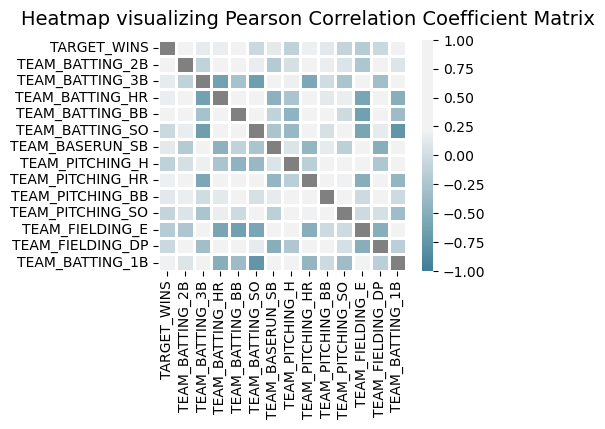

In [362]:
# Masking the diagonal cells   
masking = np.zeros_like(corr, dtype = bool)  
np.fill_diagonal(masking, val = True)  
  
# Initializing a matplotlib figure  
figure, axis = plt.subplots(figsize = (4, 3))  
  
# Generating a custom colormap  
c_map = sns.diverging_palette(223, 14, as_cmap = True, sep = 100)  
c_map.set_bad('grey')  
  
# Displaying the heatmap with the masking and the correct aspect ratio  
sns.heatmap(corr, mask = masking, cmap = c_map, vmin = -1, vmax = 1, center = 1, linewidths = 1)  
figure.suptitle('Heatmap visualizing Pearson Correlation Coefficient Matrix', fontsize = 14)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 10) 

# Train Split

In [363]:
train_df = train_df.drop(['TEAM_FIELDING_DP'], axis=1)
#train_df.dropna(inplace=True)
X = train_df.drop(['TARGET_WINS'], axis=1).values
y = train_df['TARGET_WINS']

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
print(X_train.shape, y_train.shape)

(1593, 12) (1593,)


# Transform

In [375]:
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_trf = imp_num.fit_transform(X_train)
trf_df = pd.DataFrame(X_train_trf)

In [376]:
trf_df.isnull().sum() / len(trf_df)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
dtype: float64

In [377]:
X_test_trf = imp_num.transform(X_test)
trf_df = pd.DataFrame(X_test_trf)

In [378]:
trf_df.isnull().sum() / len(trf_df)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
dtype: float64

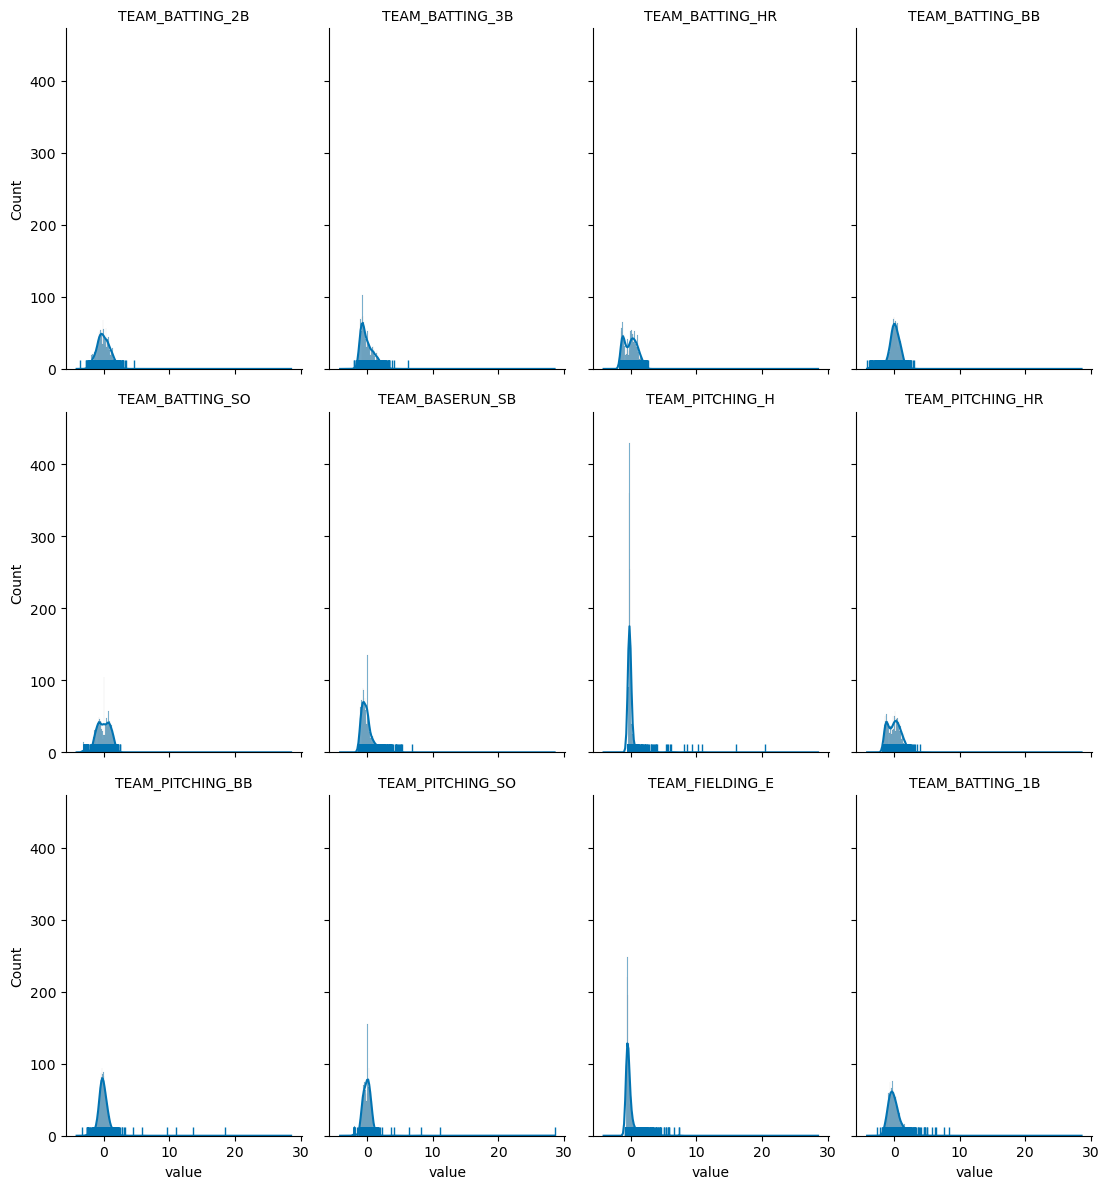

In [379]:
scaler_sd = StandardScaler()
X_train_sd = scaler_sd.fit_transform(X_train_trf)

sd_df = pd.DataFrame(X_train_sd)
sd_df.columns = np.delete(train_df.columns, np.where(train_df.columns == 'TARGET_WINS')).values
sd_df = pd.melt(sd_df)


g = sns.displot(data=sd_df, x="value", col="variable", col_wrap=4, rug=True,
                 height=4, aspect=.7, kde=True)

g.set_axis_labels("value")
g.set_titles("{col_name}")

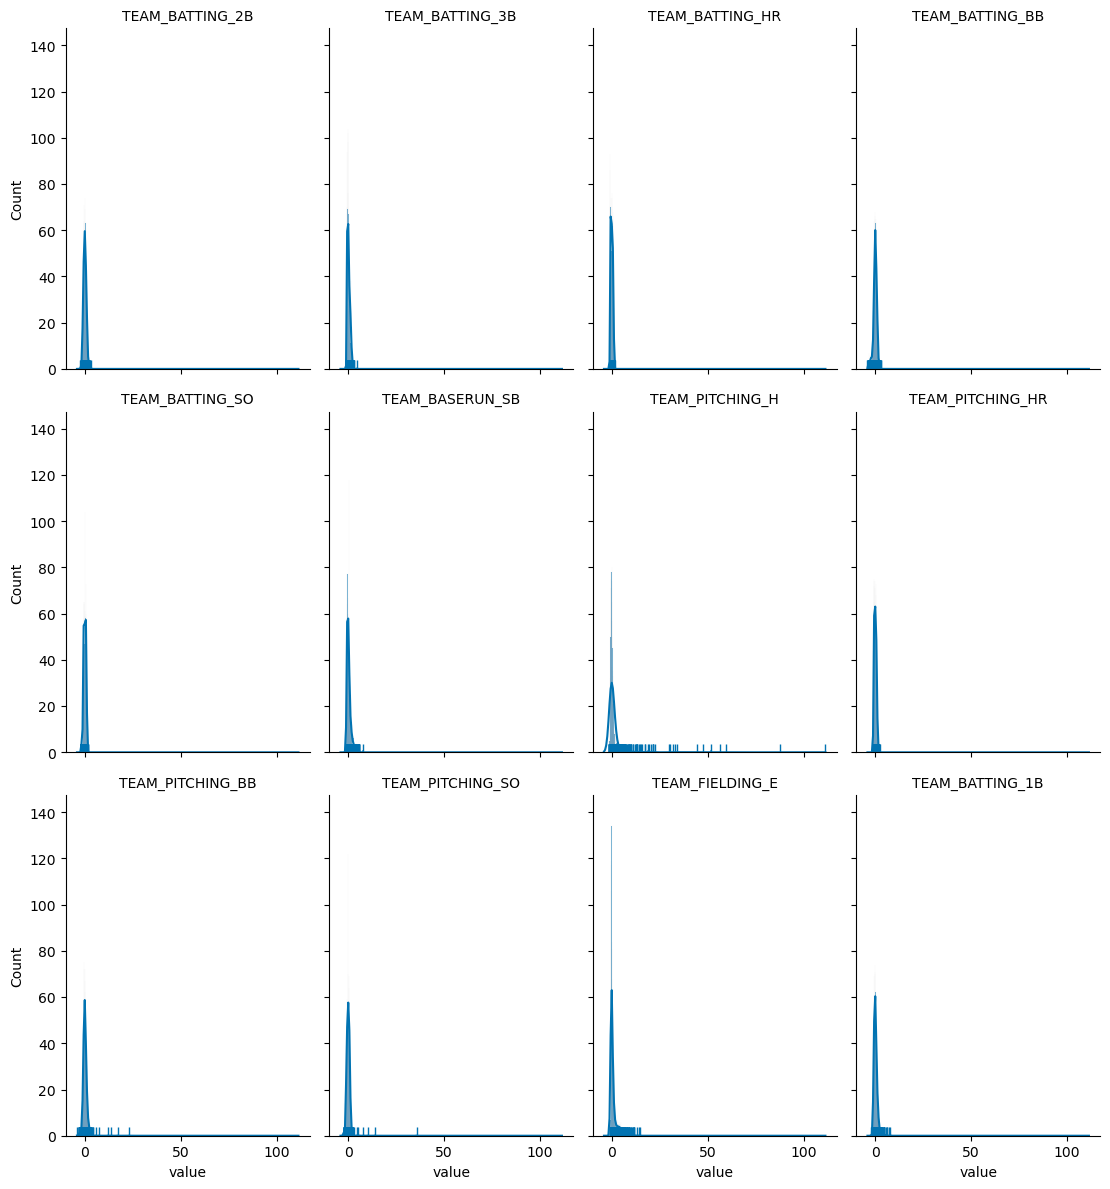

In [380]:
scaler_rs = RobustScaler()
X_train_rs = scaler_rs.fit_transform(X_train_trf)

rs_df = pd.DataFrame(X_train_rs)
rs_df.columns = np.delete(train_df.columns, np.where(train_df.columns == 'TARGET_WINS')).values
rs_df = pd.melt(rs_df)

g = sns.displot(data=rs_df, x="value", col="variable", col_wrap=4, rug=True,
                 height=4, aspect=.7, kde=True)

g.set_axis_labels("value")
g.set_titles("{col_name}")

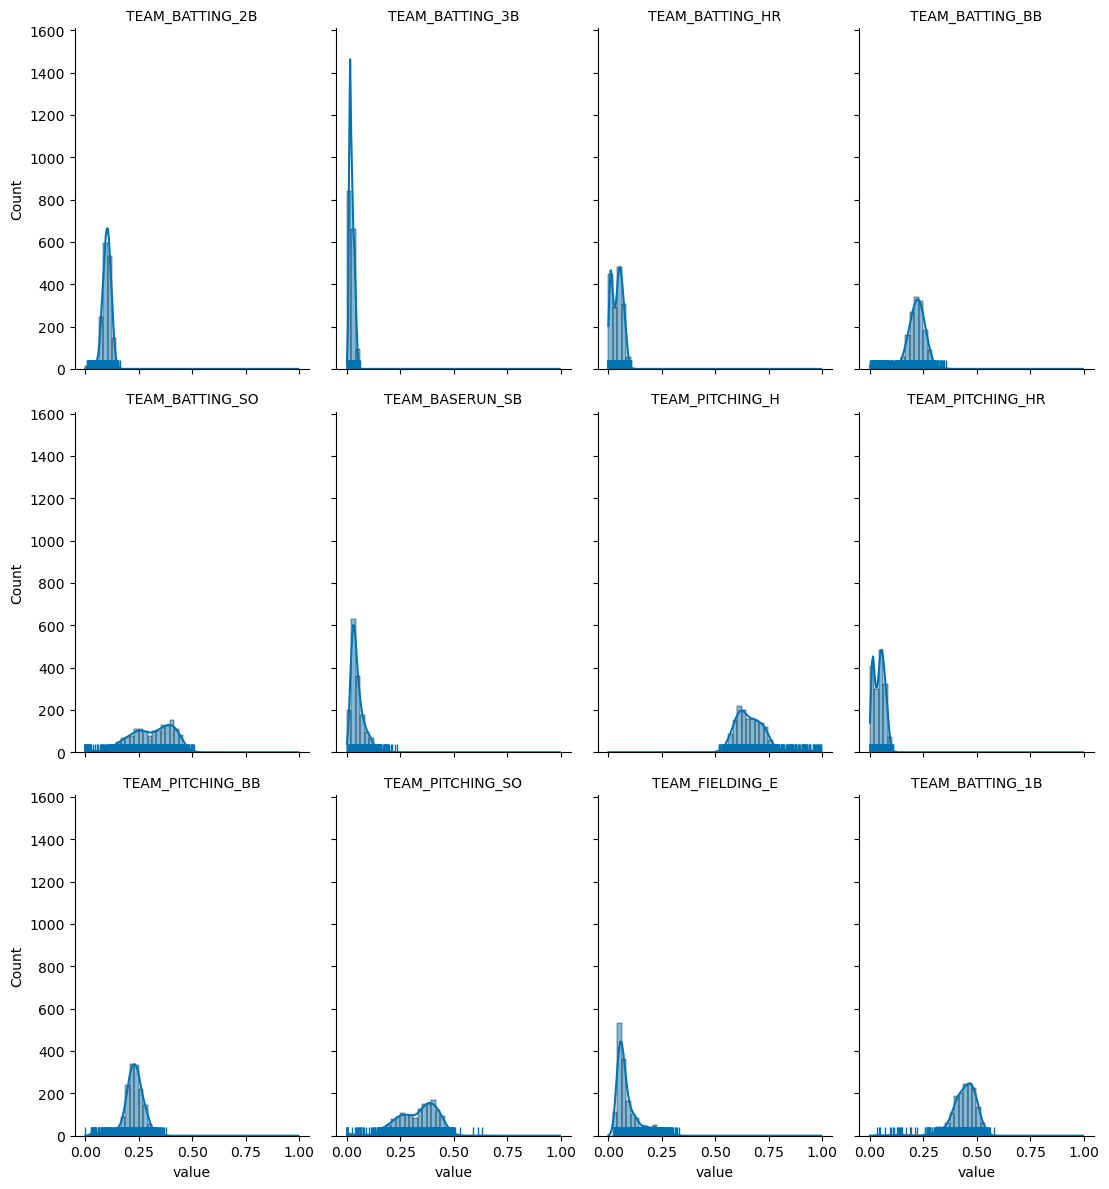

In [381]:
scaler_norm = Normalizer()
X_train_norm = scaler_norm.fit_transform(X_train_trf)

norm_df = pd.DataFrame(X_train_norm)
norm_df.columns = np.delete(train_df.columns, np.where(train_df.columns == 'TARGET_WINS')).values
norm_df = pd.melt(norm_df)


g = sns.displot(data=norm_df, x="value", col="variable", col_wrap=4, rug=True,
                 height=4, aspect=.7, kde=True)

g.set_axis_labels("value")
g.set_titles("{col_name}")

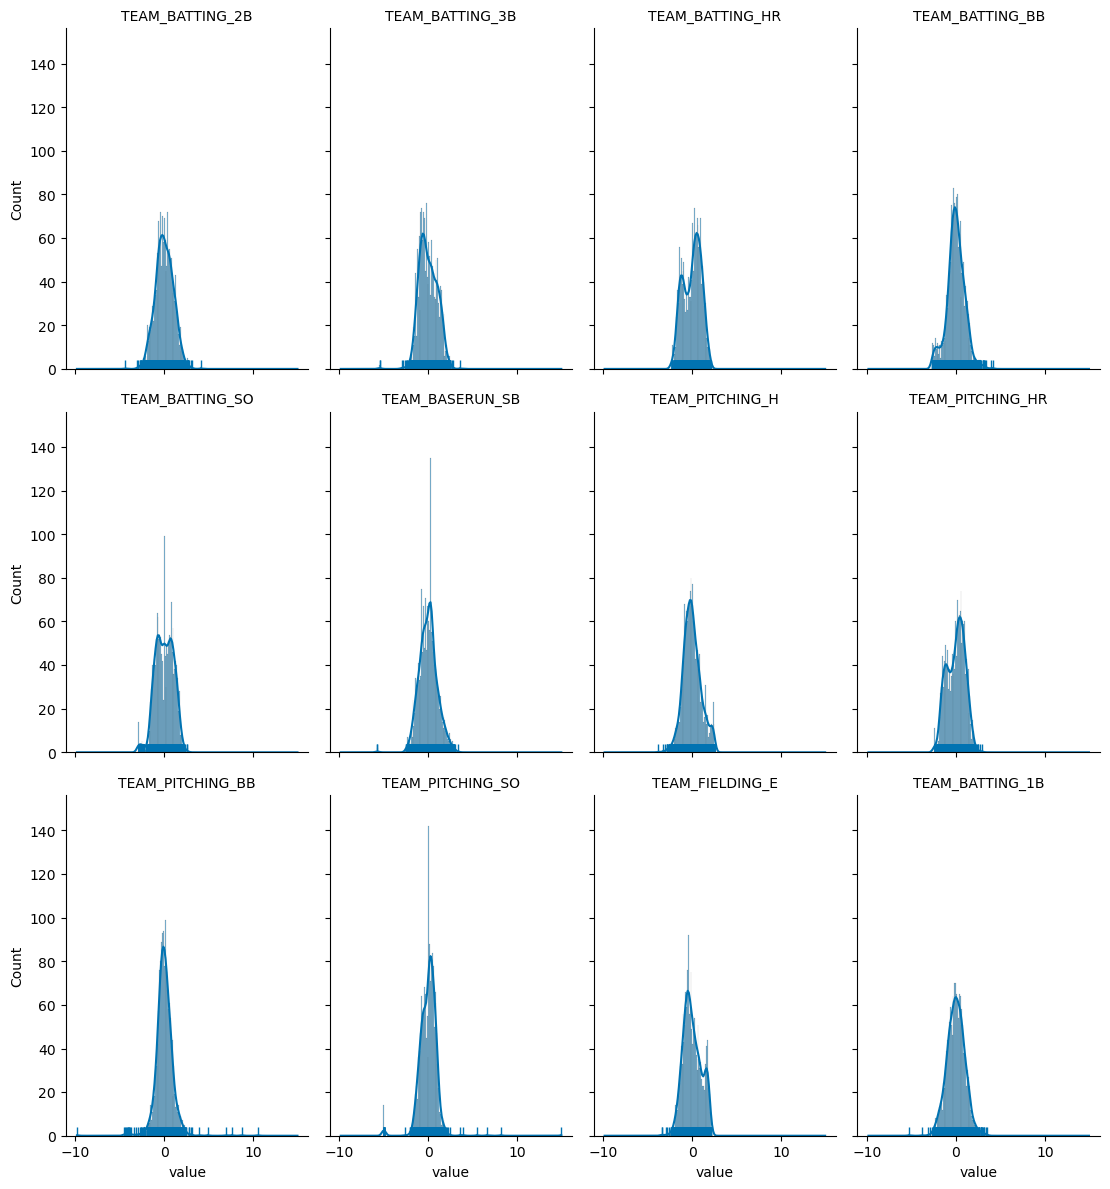

In [382]:
scaler_pwr = PowerTransformer()
X_train_pwr = scaler_pwr.fit_transform(X_train_trf)

pwr_df = pd.DataFrame(X_train_pwr)
pwr_df.columns = np.delete(train_df.columns, np.where(train_df.columns == 'TARGET_WINS')).values
pwr_df = pd.melt(pwr_df)


g = sns.displot(data=pwr_df, x="value", col="variable", col_wrap=4, rug=True,
                 height=4, aspect=.7, kde=True)

g.set_axis_labels("value")
g.set_titles("{col_name}")

In [383]:
x_dict = {"orig":X_train_trf,"sd":X_train_sd,"rs":X_train_rs,"norm":X_train_norm, "pwr":X_train_pwr}

# Model - LinearRegression

orig ) Best Accuracy Score:  0.2513
sd ) Best Accuracy Score:  0.2513
rs ) Best Accuracy Score:  0.2513
norm ) Best Accuracy Score:  0.2001
pwr ) Best Accuracy Score:  0.226


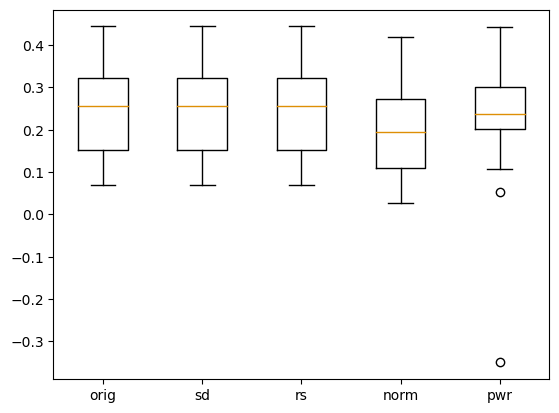

In [384]:
results = []

reg = LinearRegression()

for name, x in x_dict.items():
    kf = KFold(n_splits=20, random_state=42, shuffle=True)
    cv_results = cross_val_score(reg, x, y_train, cv=kf)
    results.append(cv_results)
    
    print(name, ') Best Accuracy Score: ' ,np.average(cv_results).round(4))
    
plt.boxplot(results, labels=x_dict.keys())
plt.show()

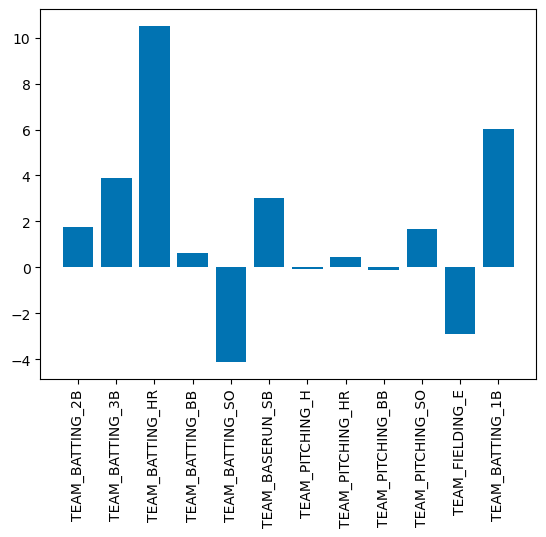

In [404]:
reg.fit(x_dict['rs'], y_train)

#print("Tuned Regression Parameters: {}".format(reg.best_params_))
#print("Tuned Regression Best Accuracy Score: {}".format(reg.best_score_))

#alpha_fit = lasso_cv.best_params_['alpha']
#alpha_fit

names = train_df.drop("TARGET_WINS", axis=1).columns
reg = LinearRegression()
reg_coef = reg.fit(x_dict['rs'], y_train).coef_
plt.bar(names, reg_coef)
plt.xticks(rotation=90)
plt.show()

## Predict

In [385]:
X_test_sd = scaler_rs.transform(X_test_trf)

In [386]:
y_pred = cross_val_predict(reg, X_test_sd, y_test)

## Performance

In [387]:
# model evaluation for testing set

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 10.539971908711522
MSE is 202.1974676122515
R2 score is 0.17820481991631298


# Model - Ridge Regression - HP Grid Search

orig ) Best Accuracy Score:  0.2806    Parameters: {} {'tol': 9.898990909090909, 'alpha': 10.0}
sd ) Best Accuracy Score:  0.2813    Parameters: {} {'tol': 9.090918181818182, 'alpha': 5.3535818181818176}
rs ) Best Accuracy Score:  0.2813    Parameters: {} {'tol': 4.747527272727273, 'alpha': 2.7273454545454547}
norm ) Best Accuracy Score:  0.1988    Parameters: {} {'tol': 6.464681818181818, 'alpha': 0.0001}
pwr ) Best Accuracy Score:  0.2545    Parameters: {} {'tol': 9.898990909090909, 'alpha': 10.0}


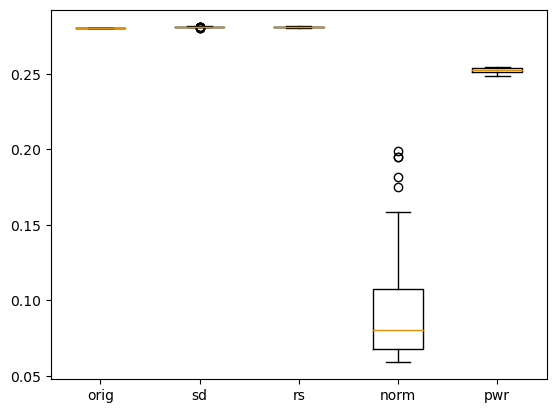

In [388]:
results_ridge = []

ridge = Ridge()
n_splits = 10
n_iter = 100
random_state = 42

#cmap_data = plt.cm.Paired
#cmap_cv = plt.cm.coolwarm
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#params = {"alpha" : np.linspace(0.0001, 100.0, 100),
#         "tol": np.linspace(0.0001, 200.0, 100)}

params = {"alpha" : np.linspace(0.0001, 1, 100)}

ridge_cv = RandomizedSearchCV(ridge, params, cv=kf, n_iter=n_iter, random_state=random_state)

# Loop through 
for name, x in x_dict.items():
    ridge_cv.fit(x,y_train)
    #kf = KFold(n_splits=20, random_state=42, shuffle=True)
    #cv_results = pd.DataFrame(ridge_cv.cv_results_)[['rank_test_score','param_alpha','param_tol','mean_test_score']].sort_values(['rank_test_score'])
    cv_results = ridge_cv.cv_results_['mean_test_score']
    results_ridge.append(cv_results)
    
    print(name, ') Best Accuracy Score: ' ,ridge_cv.best_score_.round(4), "   Parameters: {}" , ridge_cv.best_params_)
    
plt.boxplot(results_ridge, labels=x_dict.keys())
plt.show()

Tuned Regression Parameters: {'tol': 4.747527272727273, 'alpha': 2.7273454545454547}
Tuned Regression Best Accuracy Score: 0.2813064950779577


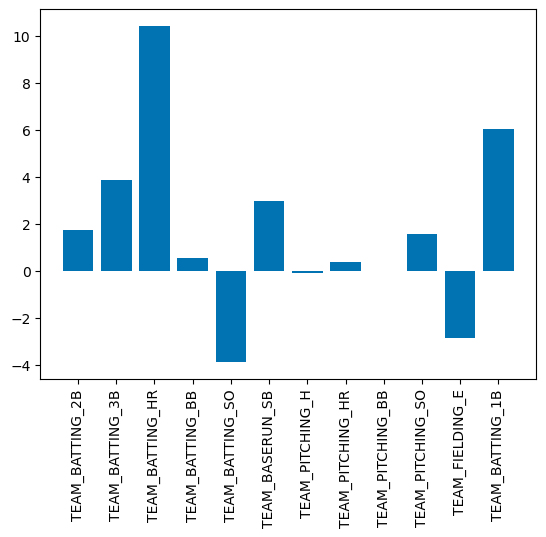

In [405]:
ridge_cv.fit(x_dict['rs'], y_train)

print("Tuned Regression Parameters: {}".format(ridge_cv.best_params_))
print("Tuned Regression Best Accuracy Score: {}".format(ridge_cv.best_score_))

alpha_fit = lasso_cv.best_params_['alpha']
alpha_fit

names = train_df.drop("TARGET_WINS", axis=1).columns
lasso = Lasso(alpha=alpha_fit)
lasso_coef = lasso.fit(x_dict['rs'], y_train).coef_
plt.bar(names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Predict

In [389]:
X_test_rs = scaler_rs.transform(X_test_trf)
y_pred = ridge_cv.predict(X_test_rs)

## Performance

In [390]:
# model evaluation for testing set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 11.468100828602317
MSE is 254.42413755629565
R2 score is -0.03406107113897372


# Model - Lasso - Grid Search

orig ) Best Accuracy Score:  0.2746    Parameters: {} {'alpha': 0.1}
sd ) Best Accuracy Score:  0.275    Parameters: {} {'alpha': 0.010000000000000002}
rs ) Best Accuracy Score:  0.275    Parameters: {} {'alpha': 0.007}
norm ) Best Accuracy Score:  0.2052    Parameters: {} {'alpha': 0.003}
pwr ) Best Accuracy Score:  0.2563    Parameters: {} {'alpha': 0.036000000000000004}


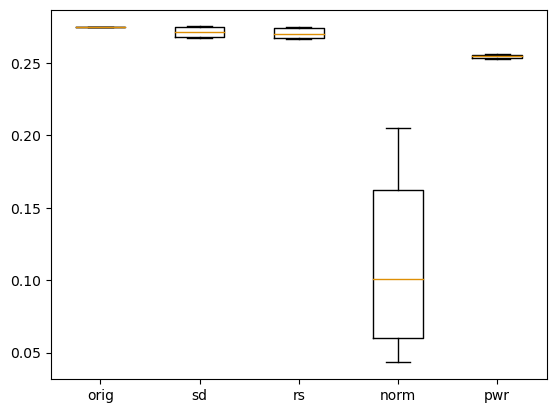

In [399]:
results_lasso = []

lasso = Lasso()
n_splits = 10
n_iter=100
random_state=42


kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#params = {"alpha" : np.linspace(0.0001, 10.0, 100),
#         "tol": np.linspace(0.0001, 10.0, 100)}

params = {"alpha" : np.linspace(0.001, 0.1, 100)}

lasso_cv = RandomizedSearchCV(lasso, params, cv=kf, n_iter=n_iter, random_state=random_state)

# Loop through 
for name, x in x_dict.items():
    lasso_cv.fit(x,y_train)
    cv_results = lasso_cv.cv_results_['mean_test_score']
    results_lasso.append(cv_results)
    
    print(name, ') Best Accuracy Score: ' ,lasso_cv.best_score_.round(4), "   Parameters: {}" , lasso_cv.best_params_)
    
plt.boxplot(results_lasso, labels=x_dict.keys())
plt.show()

Tuned Regression Parameters: {'alpha': 0.010000000000000002}
Tuned Regression Best Accuracy Score: 0.2750281951489896


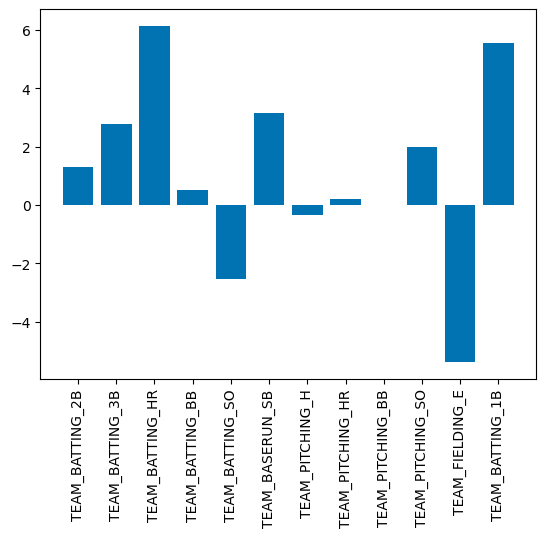

In [406]:
lasso_cv.fit(x_dict['sd'], y_train)

print("Tuned Regression Parameters: {}".format(lasso_cv.best_params_))
print("Tuned Regression Best Accuracy Score: {}".format(lasso_cv.best_score_))

alpha_fit = lasso_cv.best_params_['alpha']
alpha_fit

names = train_df.drop("TARGET_WINS", axis=1).columns
lasso = Lasso(alpha=alpha_fit)
lasso_coef = lasso.fit(x_dict['sd'], y_train).coef_
plt.bar(names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Predict

In [407]:
X_test_rs = scaler_rs.transform(X_test_trf)
y_pred = lasso_cv.predict(X_test_rs)

## Performance

In [408]:
# model evaluation for testing set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 11.232284579664988
MSE is 225.96192649613766
R2 score is 0.08161845808548229
